# IMPORTAR LAS LIBRERIAS

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Autocompletar
%config IPCompleter.greedy = True

#Transformación de datos
from sklearn.preprocessing import LabelEncoder

#Modelización
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# CARGAR LOS DATOS

## Cargar los datos

In [2]:
df = pd.read_excel('../../02_Datos/01_Originales/StudentKnowledgelevel.xls',sheet_name= 'Training_Data').iloc[:,:6]

## Variables finales

In [3]:
variables_finales = ['stg','scg','str','lpr','peg']

# ESTRUCTURA DE LOS DATASETS

## Corregir los nombres

In [4]:
df.rename(columns={'STG':'stg',
                   'SCG':'scg',
                   'STR':'str',
                   'LPR':'lpr',
                   'PEG':'peg',
                   ' UNS':'level'
                   },inplace=True)

## Para la X

In [6]:
x = df[variables_finales].copy()
x.head()

,stg,scg,str,lpr,peg
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


## Para la Y

In [7]:
y = df.level.copy()
y.head()

0    very_low
1        High
2         Low
3      Middle
4         Low
Name: level, dtype: object

## Transformación de variables

In [11]:
le = LabelEncoder()
le.fit(y)

y = le.transform(y)

## Instanciar el modelo

In [14]:
modelo = XGBClassifier(n_jos = -1, 
                     learning_rate = 0.025,
                     max_depth = 20,
                    reg_alpha = 0.5,
                     verbosity=0 ,#para que no salgan warnings
                     reg_lambda = 1,
                     n_estimators = 100,
                     multi_class = 'ovr')

## Entrenar el modelo

In [15]:
modelo.fit(x,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_class='ovr', n_estimators=100, n_jobs=None, n_jos=-1,
              num_parallel_tree=None, ...)

## Evaluar sobre validación

In [26]:
df_Val = pd.read_excel('../../02_Datos/01_Originales/StudentKnowledgelevel.xls',sheet_name= 'Test_Data').iloc[:,:6]
#renombramos las variables
df_Val.rename(columns={'STG':'stg',
                   'SCG':'scg',
                   'STR':'str',
                   'LPR':'lpr',
                   'PEG':'peg',
                   ' UNS':'level'
                   },inplace=True)
#Transformación de la label
le = LabelEncoder()
le.fit(df_Val['level'])

df_Val['level'] = le.transform(df_Val['level'])
#Designamos variables finales
variables_finales = ['stg','scg','str','lpr','peg']
#para la x
val_x = df_Val[variables_finales].copy()
val_y = df_Val.level.copy()

### Predecir sobre la validación

In [28]:
pred = modelo.predict(val_x)

### Evaluar sobre la validación

In [30]:
print(classification_report(val_y,pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        39
           1       0.84      0.93      0.89        46
           2       0.93      0.79      0.86        34
           3       0.96      0.88      0.92        26

    accuracy                           0.91       145
   macro avg       0.92      0.90      0.91       145
weighted avg       0.91      0.91      0.91       145



ROC CHART MULTICLASS

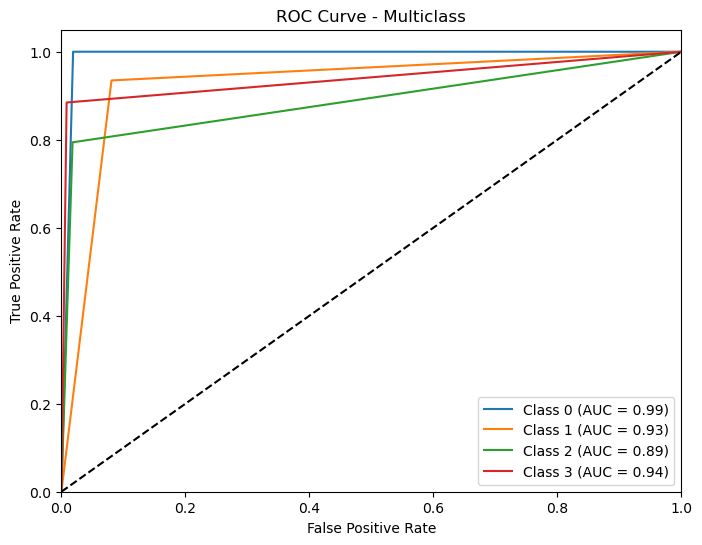

In [32]:
# Binarizar las etiquetas verdaderas y las predicciones para cada clase
n_classes = len(np.unique(val_y))
binarized_val_y = label_binarize(val_y, classes=np.arange(n_classes))
binarized_pred = label_binarize(pred, classes=np.arange(n_classes))

# Calcular la curva ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_val_y[:, i], binarized_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear el gráfico ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# Configurar etiquetas y título del gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc="lower right")